In [1]:
import os
from utils.auxiliary_func import *
from utils.plots_func import *
from flim_analysis.spatial_analysis.spatial_func import *
import config.const as const

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import tifffile
from tqdm import tqdm
from skimage.util import img_as_ubyte

### Note on Data Preparation

The data used in this notebook was generated in the following notebook:

**`flim_analysis/spatial_analysis/spatial_information.ipynb`**

Please make sure to run that notebook first to prepare the necessary data files before executing this one.

## Define Parameters

In [2]:
patch_size = 1500
overlap = 0.75
fold_method='stratified_kfold'

In [3]:
figure_2_dir = os.path.join(const.BASE_DIR, 'figure_results', 'Figure 2')
os.makedirs(figure_2_dir, exist_ok=True)

DATA_PREPARATION_DIR = const.DATA_PREPARATION_DIR

FIGURE_SUPPLEMENTARY_DIR = const.FIGURE_SUPPLEMENTARY_DIR


## Probability maps

In [4]:
file_path = os.path.join(DATA_PREPARATION_DIR, f'mean_prob_patch_size_{patch_size}_for_each_nucleus.csv')
flim_classification_probabilities = pd.read_csv(file_path, dtype={'leap_ID': str})

In [5]:
flim_classification_probabilities.head()

,nucleus_label,leap_ID,lifetime_mean,X coordinate,Y coordinate,category,prob_results
0,1,015,4.114694,3662.775510,1900.285714,non responder,0.510318
1,1,017,4.067597,2863.145161,3150.403226,non responder,0.636030
2,1,019,4.099839,3291.403226,1459.112903,non responder,0.775295
3,1,021,4.631462,2815.384615,2049.615385,responder,0.242873
4,1,023,4.368353,2224.588235,1628.117647,responder,0.489741


### Plot the probability maps

In [6]:
# Split into two groups
responders = flim_classification_probabilities[
    flim_classification_probabilities["category"] == "responder"
]["leap_ID"].unique()

non_responders = flim_classification_probabilities[
    flim_classification_probabilities["category"] == "non responder"
]["leap_ID"].unique()

groups = {
    "Responders": responders,
    "Non-Responders": non_responders,
}


Responders:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()
Responders:   3%|▎         | 1/30 [00:01<00:47,  1.63s/it]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()
Responders:   7%|▋         | 2/30 [00:02<00:37,  1.32s/it]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colorm

Responders
Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/probability_maps_Responders.png


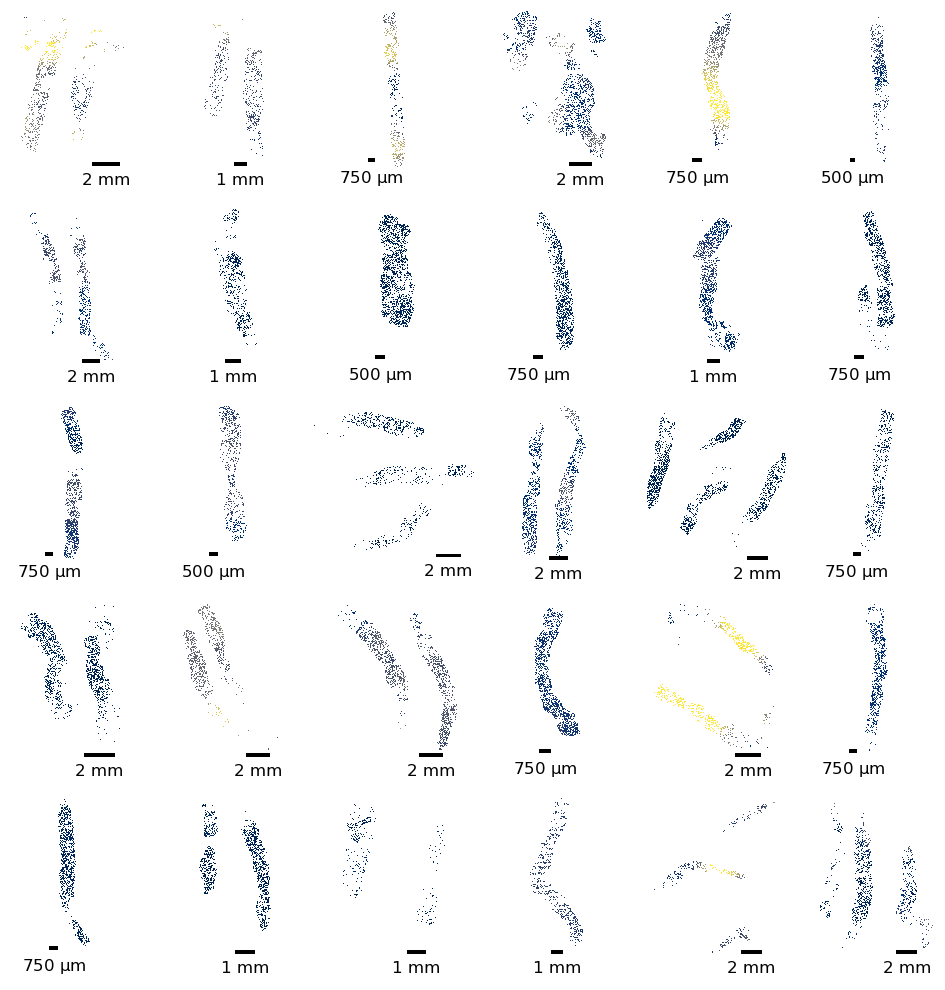

Non-Responders:   0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()
Non-Responders:   4%|▍         | 1/23 [00:01<00:40,  1.82s/it]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()
Non-Responders:   9%|▊         | 2/23 [00:04<00:48,  2.32s/it]/tmp/ipykernel_3065359/1844477825.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matpl

Non-Responders
Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/probability_maps_Non-Responders.png


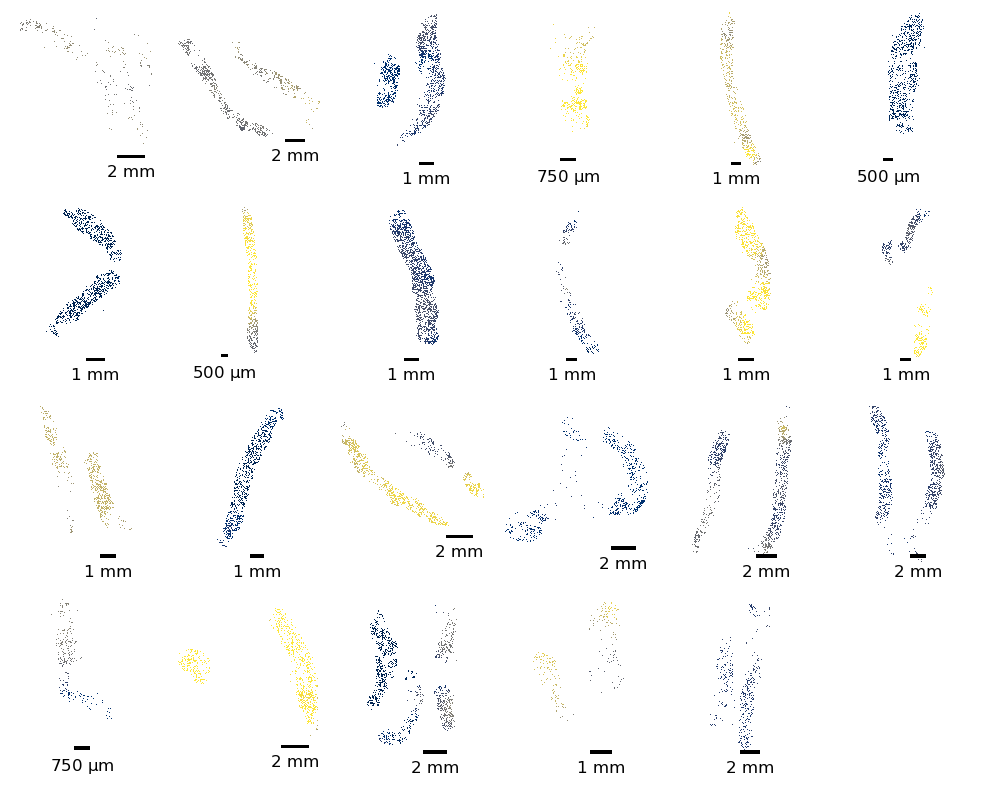

In [10]:

for group_name, leap_ids in groups.items():
    total_panels = len(leap_ids)
    ncols = 6
    nrows = int(np.ceil(total_panels / ncols))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(10, 2 * nrows), constrained_layout=True
    )

    if total_panels == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for leap_num, ax in tqdm(zip(leap_ids, axes), total=total_panels, desc=group_name):
        leap_id = f"{str(leap_num).zfill(3)}"

        flim_prob_path = os.path.join(const.FLIM_MODEL_PROBABILITY_DIR, f'Leap{leap_id}_flim_probability.tif')

        flim_single_nuclear_probabilities = io.imread(flim_prob_path)


        # Add padding below each image for the scalebar
        flim_padded = np.pad(
            flim_single_nuclear_probabilities, ((0, 2200), (0, 0)), mode='constant', constant_values=np.nan
        )

        cmap_params = cm.get_cmap("cividis_r").copy()
        cmap_params.set_bad(color='white')  # where NaN → white

        masked_img = np.ma.masked_invalid(flim_padded)

        
        ax.imshow(
            masked_img,
            cmap=cmap_params,
            vmax=1.0,
            vmin=0.0,
            interpolation="nearest",
        )

        resolution = 1.139

        scalebar = ScaleBar(
            resolution, "µm", length_fraction=0.3, location="lower right",
            box_alpha=0, width_fraction=0.02, font_properties={'size': 12}
        )

        # scalebar_main.set_font_properties({"size": 10, "weight": "bold"})

        ax.add_artist(scalebar)
        ax.axis("off")

    # Turn off unused axes
    for ax in axes[total_panels:]:
        ax.axis("off")

    print(f"{group_name}")
    plt.tight_layout()

    save_file_name = f"probability_maps_{group_name}"
    save_fig(FIGURE_SUPPLEMENTARY_DIR, save_file_name, 'png', plt, transparent=False)
    
    plt.show()


## Probability vs lifetime value analysis

In [14]:
radii = [40, 80, 120]
radius_colors = {40: 'orange', 80: 'blue', 120: 'gray'}

In [15]:
file_path = os.path.join(DATA_PREPARATION_DIR, f'mean_prob_patch_size_{patch_size}_for_each_nucleus.csv')

best_hist_aggregated_df_1500 = pd.read_csv(file_path, dtype={'leap_ID': str})
best_hist_aggregated_df_1500.head(2)

,nucleus_label,leap_ID,lifetime_mean,X coordinate,Y coordinate,category,prob_results
0,1,015,4.114694,3662.775510,1900.285714,non responder,0.510318
1,1,017,4.067597,2863.145161,3150.403226,non responder,0.636030


In [16]:
file_name = 'all_probability_coords.csv'
prob_coords_leap_file_path = os.path.join(DATA_PREPARATION_DIR, file_name)
prob_coords_df = pd.read_csv(prob_coords_leap_file_path, dtype={'leap_ID':str})
prob_coords_df.head(2)

,transition_type,leap_ID,index,shape-type,vertex-index,axis-0,axis-1
0,homogeneous_heterogeneous,073,0,path,1,5889.238610,5510.651995
1,homogeneous_heterogeneous,073,0,path,2,5499.545451,4943.825583


### Transition from Responder to Non responder region

In [17]:
transition_type = 'heterogeneous'
responder_leaps = ['066', '038']
non_responder_leaps = ['073', '048']
leaps_list = responder_leaps + non_responder_leaps

leap - 066


/tmp/ipykernel_3065359/1173629294.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()


Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/spatial_points_probs_tissue_leap_066.png


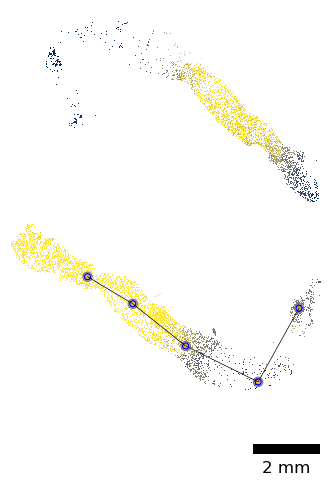

Figure saved as pdf at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/mean_lifetime_across_spatial_transition_by_radius_066.pdf


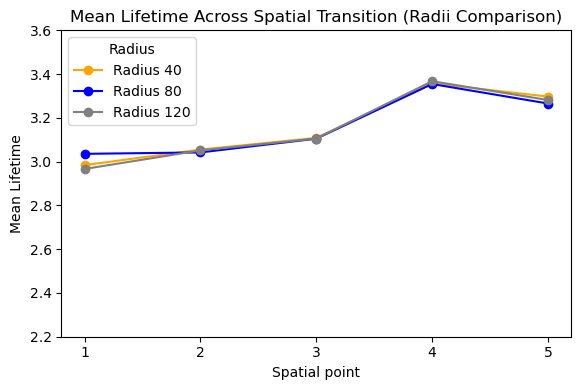

leap - 038


/tmp/ipykernel_3065359/1173629294.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()


Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/spatial_points_probs_tissue_leap_038.png


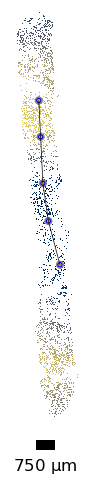

Figure saved as pdf at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/mean_lifetime_across_spatial_transition_by_radius_038.pdf


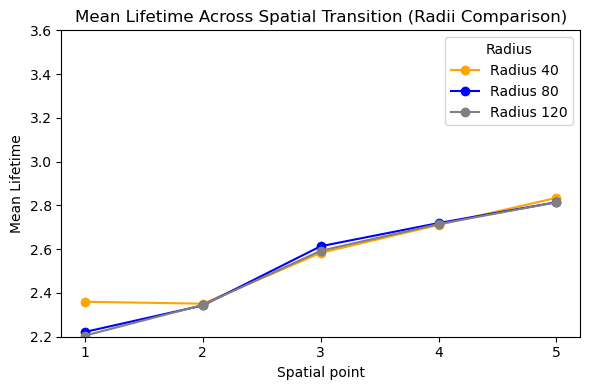

leap - 073


/tmp/ipykernel_3065359/1173629294.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()


Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/spatial_points_probs_tissue_leap_073.png


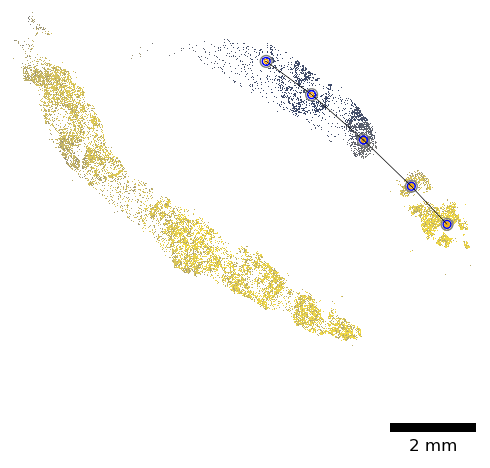

Figure saved as pdf at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/mean_lifetime_across_spatial_transition_by_radius_073.pdf


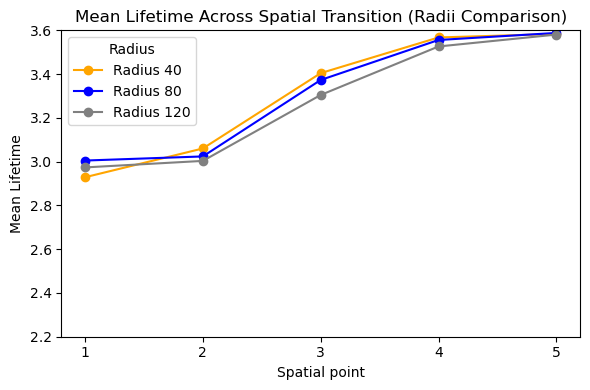

leap - 048


/tmp/ipykernel_3065359/1173629294.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_params = cm.get_cmap("cividis_r").copy()


Figure saved as png at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/spatial_points_probs_tissue_leap_048.png


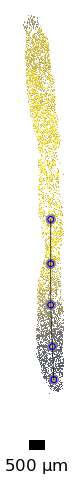

Figure saved as pdf at: /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/Supplementary/mean_lifetime_across_spatial_transition_by_radius_048.pdf


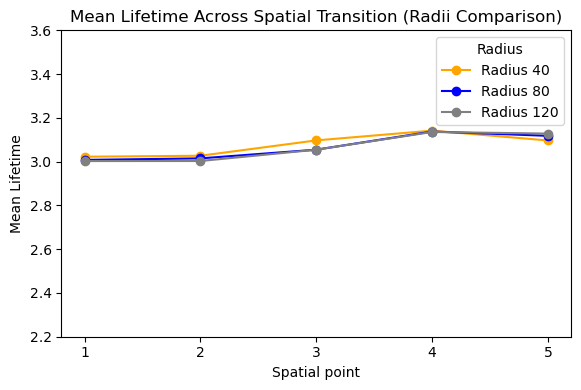

In [24]:
for leap_id in leaps_list: 
    print(f"leap - {leap_id}")
    prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
    plot_one_transition(leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, figure_save_dir=FIGURE_SUPPLEMENTARY_DIR ,save_plot=True, val_min=0.2, val_max=1)


### Transition in homogeneous region - Responder or Non responder

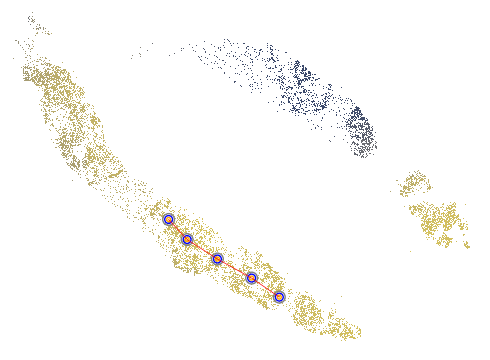

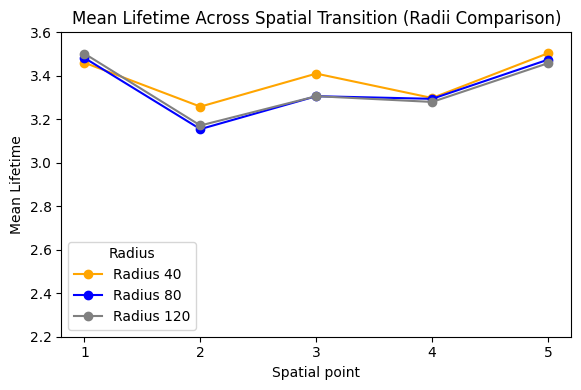

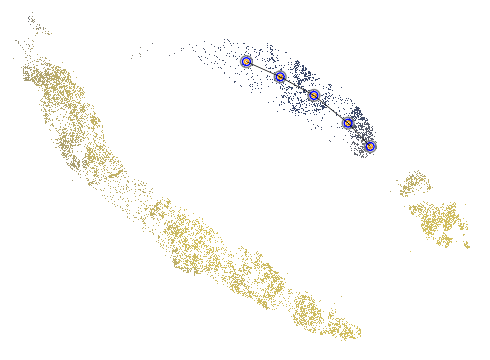

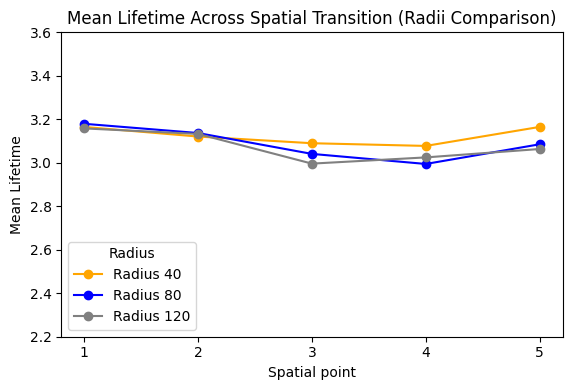

In [18]:
leap_id = '073'
transition_type = 'homogeneous'
prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
plot_one_transition(leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, path_colors = ['red', 'black'], figure_save_dir=FIGURE_SUPPLEMENTARY_DIR ,save_plot=False)


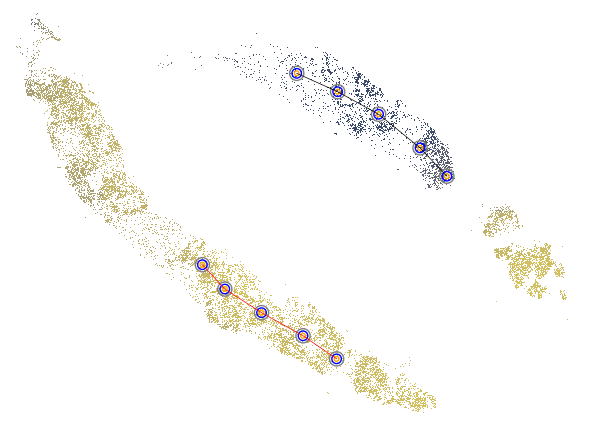

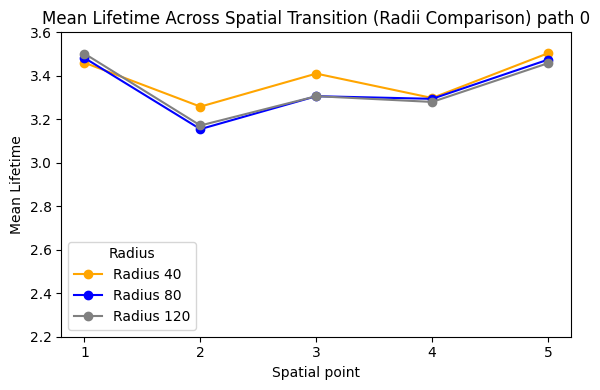

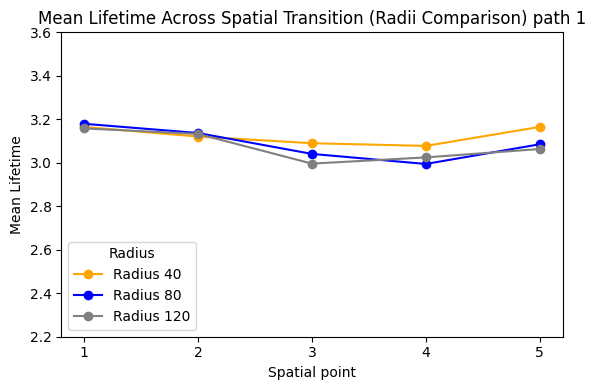

In [12]:
leap_id = '073'
transition_type = 'homogeneous'
prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
plot_transition_2_path_homo_region(val_min=0.1, leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, path_colors = ['red', 'black'], figure_save_dir=FIGURE_SUPPLEMENTARY_DIR ,save_plot=False)
